# 0. 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기


In [ ]:
df0 = pd.read_excel('/content/양주시인구데이터_0130.xlsx')
print(df0.shape)
display(df0.head(5))
display(df0.tail(5))

(102, 2)


,시간,총인구수
0,2015-06-01,210914
1,2015-07-01,211284
2,2015-08-01,211402
3,2015-09-01,211605
4,2015-10-01,211839


,시간,총인구수
97,2023-07-01,268951
98,2023-08-01,270758
99,2023-09-01,272084
100,2023-10-01,273666
101,2023-11-01,275060


In [ ]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시간      102 non-null    datetime64[ns]
 1   총인구수    102 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB


# 2. EDA(탐색적 자료 분석)

In [ ]:
ts0 = df0.copy()
ts0['시간'] = pd.to_datetime(ts0.시간, format='%Y-%m-%d')
ts0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   시간      102 non-null    datetime64[ns]
 1   총인구수    102 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB


In [ ]:
ts1 = ts0.copy()
# 연도
ts1['Year'] = ts1.시간.dt.year
# 월
ts1['Month'] = ts1.시간.dt.month
# 일
ts1['Day'] = ts1.시간.dt.day
# 요일
ts1['Day_name'] = ts1.시간.dt.day_name()
ts1

,시간,총인구수,Year,Month,Day,Day_name
0,2015-06-01,210914,2015,6,1,Monday
1,2015-07-01,211284,2015,7,1,Wednesday
2,2015-08-01,211402,2015,8,1,Saturday
3,2015-09-01,211605,2015,9,1,Tuesday
4,2015-10-01,211839,2015,10,1,Thursday
...,...,...,...,...,...,...
97,2023-07-01,268951,2023,7,1,Saturday
98,2023-08-01,270758,2023,8,1,Tuesday
99,2023-09-01,272084,2023,9,1,Friday
100,2023-10-01,273666,2023,10,1,Sunday


In [ ]:
# 필요한 column만 남기기
ts = ts1.loc[:, ['시간', '총인구수']]
# 인덱스 설정 후 drop
ts.index = ts.시간
ts = ts.drop(columns="시간")
ts

,총인구수
시간,
2015-06-01,210914
2015-07-01,211284
2015-08-01,211402
2015-09-01,211605
2015-10-01,211839
...,...
2023-07-01,268951
2023-08-01,270758
2023-09-01,272084


시각화 함수 정의

In [ ]:
# 시각화 함수 정의
def plot_ts(data, color, alpha, label):

    plt.figure(figsize=(11,5))
    plt.plot(data, color=color, alpha=alpha, label=label)
    plt.title("Mean Temperature of Bindukuri")
    plt.ylabel('Mean temperature')
    plt.legend()
    plt.show()

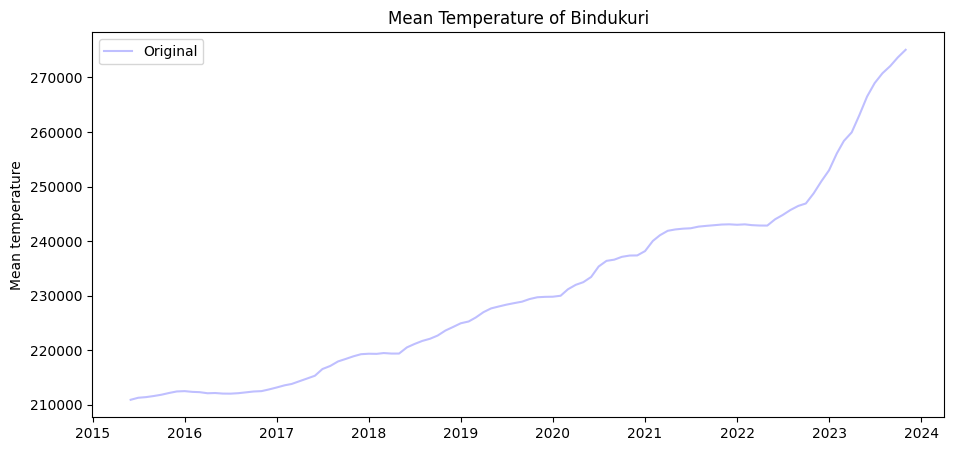

In [ ]:
plot_ts(ts, 'blue', 0.25, 'Original')

# 3. 시계열 데이터의 정상성 검정 : ADF


In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller(ts, autolag='AIC')


(2.472235257172368,
 0.9990403467671795,
 13,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 1333.772932926462)

출력값 순서\
ADF 통계량\
p-value\
usedlag (The number of lags used)\
nobs (The number of observations used for the ADF regression and calculation of the critical values.)\
critical values (기각역)\
icbest (The maximized information criterion if autolag is not None.)


ADF 결과 중 통계량, p-value, 기각역을 계산하고 출력하는 함수 정의 및 실행

In [ ]:
def ADF_test(data):
	# ADF 실시
    results = adfuller(data, autolag='AIC')

    # 통계량
    s = results[0]
    # p-value
    p = results[1]
    # 기각역
    cv = results[4]

    # 출력
    print('-'*30)
    print('Augemented Dickey-Fuller Test')
    print('H0 : 단위근이 존재한다 (비정상 시계열)')
    print('Ha : 단위근이 없다 (정상 시계열)')
    print('Critical Values : {}'.format(cv))
    print('-'*30)
    print('Test Statistics : {:.4f}'.format(s))
    print('p-value : {:.4f}'.format(p))
    print('-'*30)

# ts 데이터로 ADF 실행해보기
ADF_test(ts)

------------------------------
Augemented Dickey-Fuller Test
H0 : 단위근이 존재한다 (비정상 시계열)
Ha : 단위근이 없다 (정상 시계열)
Critical Values : {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
------------------------------
Test Statistics : 2.4722
p-value : 0.9990
------------------------------


영가설 기각할 수 없으므로 단위근이 존재함. 즉 비정상 시계열이다.


이동 평균 함수를 이용한 평균 및 표준편차 분포 시각화

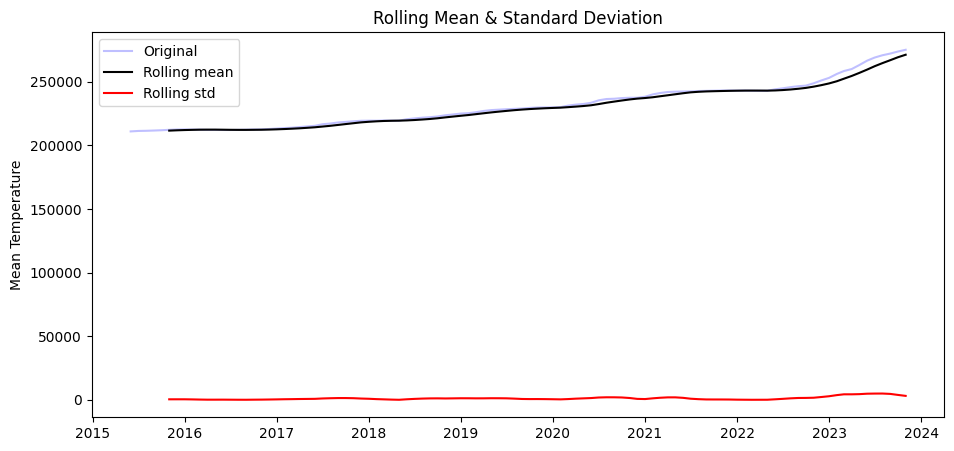

In [ ]:
def plot_rolling(data, roll_size):
    # 이동평균함수(rolling) - 평균, 표준편차
    roll_mean = data.rolling(window=roll_size).mean()
    roll_std = data.rolling(window=roll_size).std()

    # 시각화
    plt.figure(figsize=(11,5))
    plt.plot(data, color='blue', alpha=0.25, label='Original')
    plt.plot(roll_mean, color='black', label='Rolling mean')
    plt.plot(roll_std, color='red', label='Rolling std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel("Mean Temperature")
    plt.legend()
    plt.show()

# 함수 실행
plot_rolling(ts, 6)

# 4. 차분으로 정상시계열 만들기


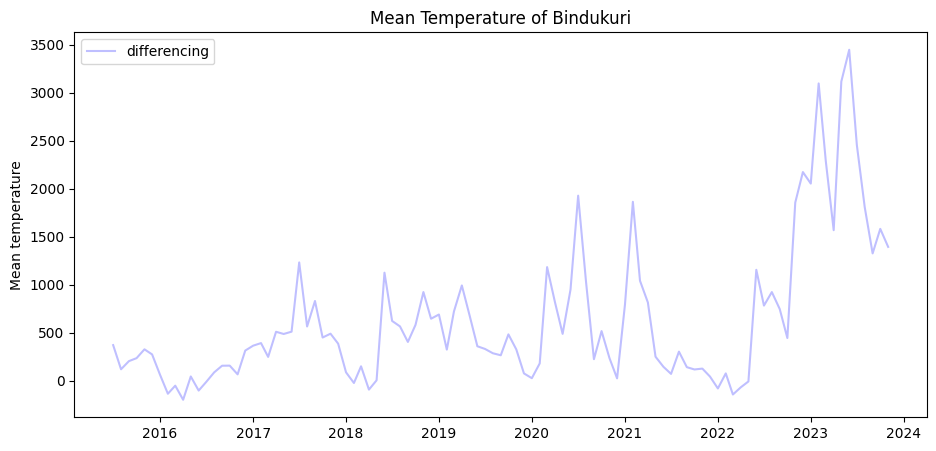

In [ ]:
# ts에서 ts.shift(1)을 빼기 (1차 차분)
ts_diff = ts - ts.shift() # default=1임

# 시각화
plot_ts(ts_diff, color='blue', alpha=0.25, label='differencing')

이동평균 시각화 및 ADF 테스트 실시

# 5. ARIMA로 평년 기온 예측하기


ACF, PACF 실시 및 시각화

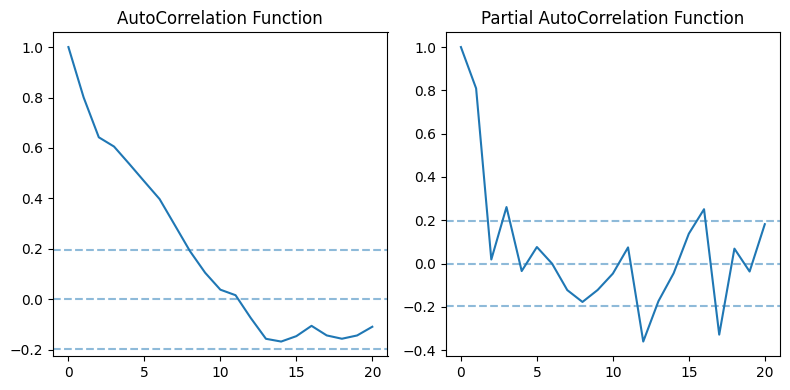

In [ ]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

# ACF
acf_20 = acf(x=ts_diff2, nlags=20)
# PACF
pacf_20 = pacf(x=ts_diff2, nlags=20, method='ols')

# 95% 신뢰구간 계산하기
confidence = 1.96/np.sqrt(len(ts_diff2))

# 시각화
plt.figure(figsize=(8,4))
# ACF
plt.subplot(1,2,1)
plt.plot(acf_20)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('AutoCorrelation Function')
# PACF
plt.subplot(1,2,2)
plt.plot(pacf_20)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('Partial AutoCorrelation Function')

plt.tight_layout()

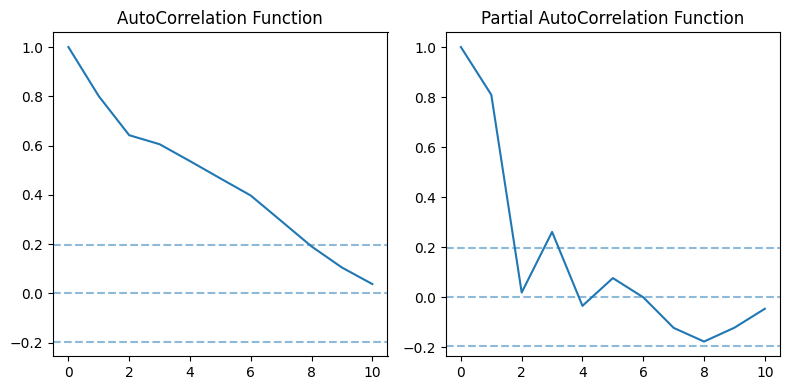

In [ ]:
# ACF
acf_10 = acf(x=ts_diff2, nlags=10)
# PACF
pacf_10 = pacf(x=ts_diff2, nlags=10, method='ols')

# 95% 신뢰구간
confidence = 1.96/np.sqrt(len(ts_diff2))

# 시각화
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(acf_10)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('AutoCorrelation Function')

plt.subplot(1,2,2)
plt.plot(pacf_10)
plt.axhline(y=0, linestyle='--', alpha=0.5)
plt.axhline(y=-confidence, linestyle='--', alpha=0.5)
plt.axhline(y=confidence, linestyle='--', alpha=0.5)
plt.title('Partial AutoCorrelation Function')

plt.tight_layout()